In [1]:
!tree

.
├── Data
│   ├── Readme.md
│   ├── count_vector.joblib
│   ├── df_train.joblib
│   ├── label_encoder.joblib
│   ├── text_train.joblib
│   ├── tf_idf.joblib
│   └── y_train.joblib
├── Models
│   ├── Readme.txt
│   ├── best_logi.joblib
│   └── model_collection.csv
├── Shiyunze_feature_engineering.ipynb
├── Shiyunze_logistic_regression.ipynb
└── Shiyuzne's_work_on_new_data_set.ipynb

2 directories, 13 files


In [1]:
# Code for hiding seaborn warnings
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
#import altair as alt
# need to 'pip install vega' before using renderer
#alt.renderers.enable("notebook")
# Code for hiding seaborn warnings
import warnings
warnings.filterwarnings("ignore")
from imblearn.over_sampling import SMOTE
from sklearn import preprocessing,metrics
from sklearn.metrics import accuracy_score,f1_score,recall_score,roc_auc_score
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve,StratifiedKFold
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.decomposition import PCA,TruncatedSVD
from sklearn.utils import shuffle
import scipy
import os
from joblib import dump, load
from sklearn.metrics import classification_report,confusion_matrix,plot_confusion_matrix
from sklearn.metrics import precision_recall_fscore_support as prfs
# test for Selecting The Best Number Of Components For TSVD
from sklearn.preprocessing import StandardScaler
from scipy.sparse import csr_matrix
# from varname import varname
%matplotlib inline
#fix random seed
np.random.seed(1)

Using TensorFlow backend.


In [2]:
TRAINING_FILE = "../keyword.csv"
TEST_FILE = "../key_word_test.csv"
df_train = pd.read_csv(TRAINING_FILE)
df_test = pd.read_csv(TEST_FILE)
print(df_train.isnull().sum())
df_train.head(5)

Unnamed: 0         0
article_number     0
article_words      0
topic              0
IR_binary          0
key_word_10       62
key_word_20       18
key_word_50        0
key_word_100       0
dtype: int64


,Unnamed: 0,article_number,article_words,topic,IR_binary,key_word_10,key_word_20,key_word_50,key_word_100
0,0,1,"open,absent,cent,cent,cent,stock,inflow,rate,k...",FOREX MARKETS,False,"stock,rate,defend,bank,bank,bank,bank,bank,dol...","cent,cent,cent,stock,rate,end,won,won,won,won,...","open,cent,cent,cent,stock,rate,end,won,won,won...","open,cent,cent,cent,stock,rate,end,won,won,won..."
1,1,2,"morn,stead,end,end,day,day,day,patch,patch,pat...",MONEY MARKETS,False,"day,day,day,bank,year,dollar,dollar,deal,deal,...","end,end,day,day,day,point,time,bank,year,dolla...","end,end,day,day,day,point,time,bank,early,year...","end,end,day,day,day,index,point,time,busi,bank..."
2,2,3,"socc,socc,world,world,recent,law,fifa,fifa,fif...",SPORTS,False,"world,world,stat,stat,stat,stat,year,releas,re...","world,world,stat,stat,stat,stat,govern,time,ye...","socc,socc,world,world,stat,stat,stat,stat,gove...","socc,socc,world,world,recent,law,stat,stat,sta..."
3,3,4,"open,forint,forint,forint,forint,cent,cent,ste...",FOREX MARKETS,False,"play,bank,bank,mark,mark,percent,percent,perce...","cent,cent,end,play,unit,bank,bank,mark,mark,pe...","open,cent,cent,end,play,unit,made,bank,bank,tu...","open,cent,cent,end,play,unit,made,bank,bank,ra..."
4,4,5,"morn,complet,weekend,minut,minut,minut,arrow,d...",IRRELEVANT,True,day,"day,time,season,clos","minut,minut,minut,day,friday,friday,race,time,...","minut,minut,minut,day,friday,friday,race,time,..."


In [3]:
df_train_50 = pd.DataFrame(df_train,columns=['key_word_50','topic']).rename(columns={'key_word_50':'key_word'})
df_train_50.name = 'df_train_50'
df_train_100 = pd.DataFrame(df_train,columns=['key_word_100','topic']).rename(columns={'key_word_100':'key_word'})
df_train_100.name = 'df_train_100'
df_train_full = pd.DataFrame(df_train,columns=['article_words','topic']).rename(columns={'article_words':'key_word'})
df_train_full.name = 'df_train_full'
df_train_all = [df_train_100,df_train_full]

df_train_100.head(3)

,key_word,topic
0,"open,cent,cent,cent,stock,rate,end,won,won,won...",FOREX MARKETS
1,"end,end,day,day,day,index,point,time,busi,bank...",MONEY MARKETS
2,"socc,socc,world,world,recent,law,stat,stat,sta...",SPORTS


In [4]:
df_test_50 = pd.DataFrame(df_test,columns=['key_word_50','topic']).rename(columns={'key_word_50':'key_word'})
df_test_50.name = 'df_test_50'
df_test_100 = pd.DataFrame(df_test,columns=['key_word_100','topic']).rename(columns={'key_word_100':'key_word'})
df_test_100.name = 'df_test_100'
df_test_full = pd.DataFrame(df_test,columns=['article_words','topic']).rename(columns={'article_words':'key_word'})
df_test_full.name = 'df_test_full'
df_test_all = [df_test_50,df_test_100,df_test_full]

df_test_50.head(3)

,key_word,topic
0,"world,chin,chin,chin,chin,chin,chin,industr,gr...",IRRELEVANT
1,"sunday,friday,eu,includ,european,report,saturday",IRRELEVANT
2,"cent,cent,cent,stock,stock,stock,rate,rate,rat...",FOREX MARKETS


In [5]:
# def get_df_name(df):
#     return ([x for x in globals() if globals()[x] is df][0])

from sklearn.linear_model import LogisticRegression

def get_scores(en_train_y,pred_y,model_name,topic=None):
    f1 = f1_score(en_train_y,pred_y,average='macro')
    accuracy = accuracy_score(en_train_y,pred_y)
    recall = recall_score(en_train_y,pred_y,average='macro')
    if(topic==None):
        print("F1 score for ",model_name," model is ",f1)
        print("Accuracy score for ",model_name," model is ",accuracy)
        print("Recall score for ",model_name," model is ",recall,"\n")
    else:
        return ([topic,{'accuracy':accuracy,'f1':f1,'recall':recall}])
def save_variable(variable,filename):
    file_name = "Models/"+filename+".joblib"
    if not os.path.exists(file_name):
    # Export the model (TFIDF+logistic regressor)
        with open(file_name, "wb") as file:
            dump(variable, file, compress=True)
    else:
        print("Warn: this model already exits...")
        
def retrieve_variable(filename):
    file_name = "Models/"+filename+".joblib"
    return(load(file_name))

def scores_for_topics(df,topics,model,le):
    scores = []
    for topic in topics:
        topic_scores(df,topic,model,le,scores)
    scores.sort(reverse=True,key=lambda x:x[1]['accuracy'])
    for item in scores:
        print(item)

def topic_scores(df,topic,model,le,scores):
    filtered_df = df[df.topic==topic]
    test_x = filtered_df.key_word.apply(lambda x: x.replace('_', ''))
    test_y = filtered_df.topic
    #le.fit(train_y)
    en_test_y = le.transform(test_y)
    prediction = model.predict(test_x)
    scores.append(get_scores(en_test_y,prediction,type(model).__name__,topic))
    
def grid_search(vectorizer,model,train_x,train_y,topics):
    kfold = StratifiedKFold(n_splits=10,shuffle=True,random_state=1)
    estimators = [
                ("vectorizer",vectorizer),
                ("model",model)
                  ]
    pipe = Pipeline(estimators)

    param_grid = {
                "vectorizer__min_df":[i for i in range(1,6)],
                "model__C":[0.0001,0.01,0.1,1,10,100],
                "model__multi_class":['auto', 'ovr', 'multinomial'],
#                 "model__class_weight": ["balanced", None]
                 }
    grid_search = GridSearchCV(pipe, param_grid, cv=kfold, n_jobs=-1)
    grid_result=grid_search.fit(train_x, train_y)
    return (grid_result.best_estimator_,grid_result.best_score_)
    
def get_model(df_train):
    # get train_x and train_y
    new_df = df_train
    new_df = new_df.dropna()
    train_x = new_df.key_word.apply(lambda x: x.replace('_', ''))
    train_y = new_df.topic
    le = preprocessing.LabelEncoder()
    le.fit(train_y)
    encode_mapping = dict(zip(le.classes_, range(len(le.classes_))))
    en_train_y = le.transform(train_y)
    topics = list(set(new_df['topic']))
    # Using SMOTE to solve imbalance
    smote = SMOTE(random_state=1)
    vectorizer = TfidfVectorizer()
    vectorizer.fit(train_x)
    train_vectors = vectorizer.transform(train_x)
    smo_x,smo_y = smote.fit_sample(train_vectors,en_train_y)
    new_train_x = vectorizer.inverse_transform(smo_x)
    new_train_x = pd.Series([','.join(item) for item in new_train_x])
    # Start grid search
    count_clf_logi,count_clf_accuracy = grid_search(CountVectorizer(),LogisticRegression(n_jobs=-1),\
                                                  new_train_x,smo_y,topics)
    tfidf_clf_logi,tfidf_clf_accuracy = grid_search(TfidfVectorizer(norm=None),LogisticRegression(n_jobs=-1),\
                                                  new_train_x,smo_y,topics)
    if(count_clf_accuracy>=tfidf_clf_accuracy):
        print(f'*************************************************************')
        print(f'Now the training set is {df_train.name}, and the model chosen is count_clf_logi')
        print(f'The accuracy is {count_clf_accuracy}')
        return (count_clf_logi,le,encode_mapping)
    else:
        print(f'*************************************************************')
        print(f'Now the training set is {df_train.name}, and the model chosen is tfidf_clf_logi')
        print(f'The accuracy is {tfidf_clf_accuracy}')
        return (tfidf_clf_logi,le,encode_mapping)
    
def test_model(df_test,model,le,encode_mapping):
    test_x = df_test.key_word
    test_y = df_test.topic
    topics = list(set(df_test['topic']))
    en_test_y = le.transform(test_y)
    y_pred = model.predict(test_x)
    get_scores(en_test_y,y_pred,type(model).__name__)
    print(encode_mapping)
    print(f"Classification Report:\n{classification_report(en_test_y, y_pred)}")
    print("The scores for each topic is:")
    scores_for_topics(df_test,topics,model,le)
    conf_matrix = confusion_matrix(en_test_y, y_pred)
    print(conf_matrix)
    fig1 = plt.figure(figsize=(13,6))
    sns.heatmap(conf_matrix,
    #             square=True,
                annot=True, # show numbers in each cell
                fmt='d', # set number format to integer in each cell
                yticklabels=le.classes_,
                xticklabels=model.classes_,
                cmap="Blues",
    #             linecolor="k",
                linewidths=.1,
               )
    plt.title(
              f"Confusion Matrix on Test Set | " 
              f"Classifier: {'+'.join([step for step in clf_logi.named_steps.keys()])}", 
              fontsize=14)
    plt.xlabel("Actual: False positives for y != x", fontsize=12)
    plt.ylabel("Prediction: False negatives for x != y", fontsize=12)
    plt.show()
    

*************************************************************
Now the training set is df_train_100, and the model chosen is tfidf_clf_logi
The accuracy is 0.9367054887710241
----------------------------------------------------------------------
Now, the train_df is df_train_100, the test_df is df_test_50
F1 score for  Pipeline  model is  0.48212573924329577
Accuracy score for  Pipeline  model is  0.62
Recall score for  Pipeline  model is  0.6329733005362296 

{'ARTS CULTURE ENTERTAINMENT': 0, 'BIOGRAPHIES PERSONALITIES PEOPLE': 1, 'DEFENCE': 2, 'DOMESTIC MARKETS': 3, 'FOREX MARKETS': 4, 'HEALTH': 5, 'IRRELEVANT': 6, 'MONEY MARKETS': 7, 'SCIENCE AND TECHNOLOGY': 8, 'SHARE LISTINGS': 9, 'SPORTS': 10}
Classification Report:
              precision    recall  f1-score   support

           0       0.43      1.00      0.60         3
           1       0.47      0.47      0.47        15
           2       0.53      0.77      0.62        13
           3       0.05      0.50      0.08         

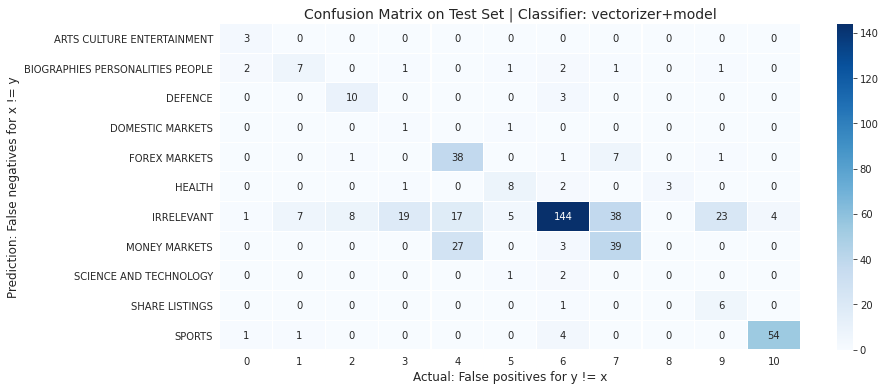

----------------------------------------------------------------------
Now, the train_df is df_train_100, the test_df is df_test_100
F1 score for  Pipeline  model is  0.48848027952071216
Accuracy score for  Pipeline  model is  0.632
Recall score for  Pipeline  model is  0.6791165737389994 

{'ARTS CULTURE ENTERTAINMENT': 0, 'BIOGRAPHIES PERSONALITIES PEOPLE': 1, 'DEFENCE': 2, 'DOMESTIC MARKETS': 3, 'FOREX MARKETS': 4, 'HEALTH': 5, 'IRRELEVANT': 6, 'MONEY MARKETS': 7, 'SCIENCE AND TECHNOLOGY': 8, 'SHARE LISTINGS': 9, 'SPORTS': 10}
Classification Report:
              precision    recall  f1-score   support

           0       0.20      0.67      0.31         3
           1       0.27      0.20      0.23        15
           2       0.48      0.77      0.59        13
           3       0.08      1.00      0.15         2
           4       0.49      0.83      0.62        48
           5       0.59      0.71      0.65        14
           6       0.91      0.54      0.68       266
        

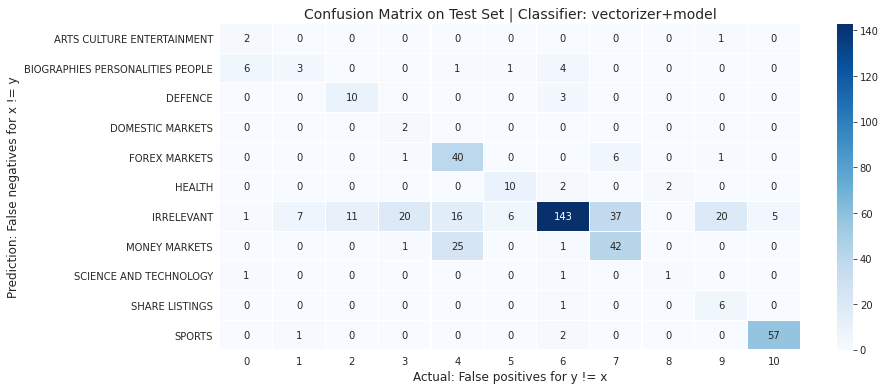

----------------------------------------------------------------------
Now, the train_df is df_train_100, the test_df is df_test_full
F1 score for  Pipeline  model is  0.48848027952071216
Accuracy score for  Pipeline  model is  0.632
Recall score for  Pipeline  model is  0.6791165737389994 

{'ARTS CULTURE ENTERTAINMENT': 0, 'BIOGRAPHIES PERSONALITIES PEOPLE': 1, 'DEFENCE': 2, 'DOMESTIC MARKETS': 3, 'FOREX MARKETS': 4, 'HEALTH': 5, 'IRRELEVANT': 6, 'MONEY MARKETS': 7, 'SCIENCE AND TECHNOLOGY': 8, 'SHARE LISTINGS': 9, 'SPORTS': 10}
Classification Report:
              precision    recall  f1-score   support

           0       0.20      0.67      0.31         3
           1       0.27      0.20      0.23        15
           2       0.48      0.77      0.59        13
           3       0.08      1.00      0.15         2
           4       0.49      0.83      0.62        48
           5       0.59      0.71      0.65        14
           6       0.91      0.54      0.68       266
       

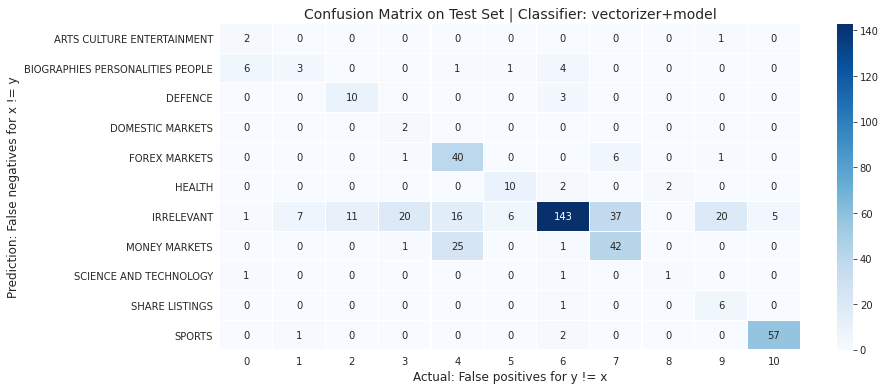

*************************************************************
Now the training set is df_train_full, and the model chosen is tfidf_clf_logi
The accuracy is 0.9729809393416696
----------------------------------------------------------------------
Now, the train_df is df_train_full, the test_df is df_test_50
F1 score for  Pipeline  model is  0.4348780516393033
Accuracy score for  Pipeline  model is  0.676
Recall score for  Pipeline  model is  0.4777148861817054 

{'ARTS CULTURE ENTERTAINMENT': 0, 'BIOGRAPHIES PERSONALITIES PEOPLE': 1, 'DEFENCE': 2, 'DOMESTIC MARKETS': 3, 'FOREX MARKETS': 4, 'HEALTH': 5, 'IRRELEVANT': 6, 'MONEY MARKETS': 7, 'SCIENCE AND TECHNOLOGY': 8, 'SHARE LISTINGS': 9, 'SPORTS': 10}
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         3
           1       0.50      0.13      0.21        15
           2       0.67      0.62      0.64        13
           3       0.09      0.50      0.15       

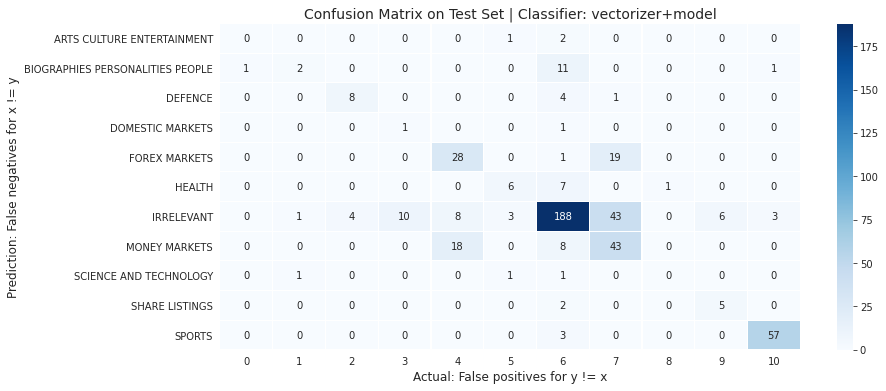

----------------------------------------------------------------------
Now, the train_df is df_train_full, the test_df is df_test_100
F1 score for  Pipeline  model is  0.477747198934852
Accuracy score for  Pipeline  model is  0.694
Recall score for  Pipeline  model is  0.5214428877758398 

{'ARTS CULTURE ENTERTAINMENT': 0, 'BIOGRAPHIES PERSONALITIES PEOPLE': 1, 'DEFENCE': 2, 'DOMESTIC MARKETS': 3, 'FOREX MARKETS': 4, 'HEALTH': 5, 'IRRELEVANT': 6, 'MONEY MARKETS': 7, 'SCIENCE AND TECHNOLOGY': 8, 'SHARE LISTINGS': 9, 'SPORTS': 10}
Classification Report:
              precision    recall  f1-score   support

           0       0.20      0.33      0.25         3
           1       0.67      0.13      0.22        15
           2       0.64      0.69      0.67        13
           3       0.14      0.50      0.22         2
           4       0.49      0.52      0.51        48
           5       0.64      0.50      0.56        14
           6       0.84      0.73      0.78       266
         

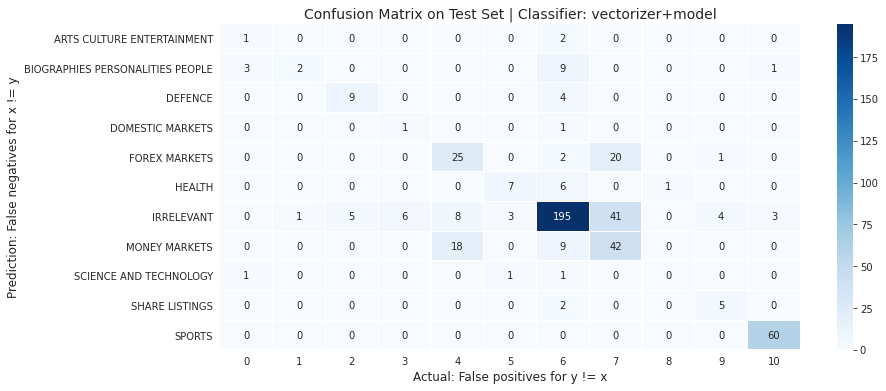

----------------------------------------------------------------------
Now, the train_df is df_train_full, the test_df is df_test_full
F1 score for  Pipeline  model is  0.5595536394109119
Accuracy score for  Pipeline  model is  0.73
Recall score for  Pipeline  model is  0.6548684534382475 

{'ARTS CULTURE ENTERTAINMENT': 0, 'BIOGRAPHIES PERSONALITIES PEOPLE': 1, 'DEFENCE': 2, 'DOMESTIC MARKETS': 3, 'FOREX MARKETS': 4, 'HEALTH': 5, 'IRRELEVANT': 6, 'MONEY MARKETS': 7, 'SCIENCE AND TECHNOLOGY': 8, 'SHARE LISTINGS': 9, 'SPORTS': 10}
Classification Report:
              precision    recall  f1-score   support

           0       0.29      0.67      0.40         3
           1       0.80      0.27      0.40        15
           2       0.71      0.77      0.74        13
           3       0.29      1.00      0.44         2
           4       0.46      0.54      0.50        48
           5       0.65      0.79      0.71        14
           6       0.90      0.77      0.83       266
        

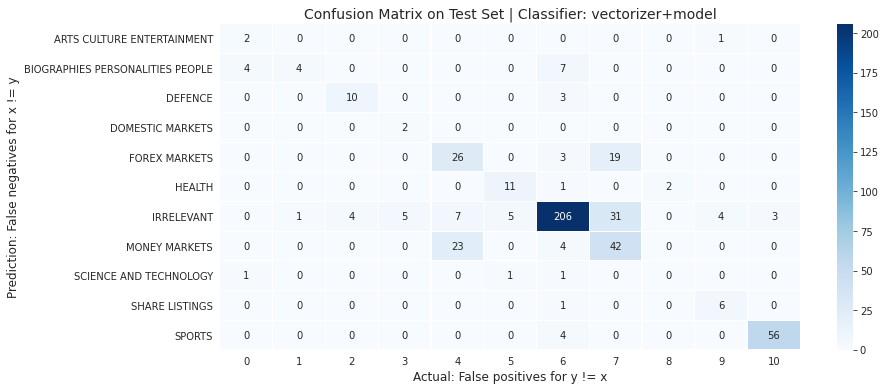

CPU times: user 3min 37s, sys: 2min 26s, total: 6min 4s
Wall time: 12h 40min 46s


In [6]:
%%time
for train_df in df_train_all:
    clf_logi,le,encode_mapping = get_model(train_df)
    for test_df in df_test_all:
#         if (test_df.isnull().values.any()):
#             continue
        print('----------------------------------------------------------------------')
        print(f'Now, the train_df is {train_df.name}, the test_df is {test_df.name}')
        test_model(test_df,clf_logi,le,encode_mapping)
        